In [2]:
# import libraries
import re
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from pprint import pprint

# gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

C:\Users\Alex\anaconda3\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [3]:
# load file
corpus_df = pd.read_csv('Donald_Trumps_Facebook_Statuses.csv', header=0)
print(corpus_df.columns)
print(len(corpus_df))
corpus_df.head(5)

Index(['status_id', 'status_message', 'link_name', 'status_type',
       'status_link', 'status_published', 'num_reactions', 'num_comments',
       'num_shares', 'num_likes', 'num_loves', 'num_wows', 'num_hahas',
       'num_sads', 'num_angrys'],
      dtype='object')
4540


,status_id,status_message,link_name,status_type,status_link,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,153080620724_10157915294545725,Beautiful evening in Wisconsin- THANK YOU for ...,Timeline Photos,photo,https://www.facebook.com/DonaldTrump/photos/a....,10/17/2016 20:56:51,6813.0,543.0,359.0,6178.0,572.0,39.0,17.0,0.0,7.0
1,153080620724_10157914483265725,The State Department's quid pro quo scheme pro...,NaN,video,https://www.facebook.com/DonaldTrump/videos/10...,10/17/2016 18:00:41,33768.0,3644.0,17653.0,26649.0,487.0,1155.0,75.0,191.0,5211.0
2,153080620724_10157913199155725,Crooked Hillary's State Department colluded wi...,NaN,video,https://www.facebook.com/DonaldTrump/videos/10...,10/17/2016 15:34:46,85627.0,8810.0,32594.0,73519.0,2943.0,1020.0,330.0,263.0,7552.0
3,153080620724_10157912962325725,"JournoCash: Media gives $382,000 to Clinton, $...","JournoCash: Media gives $382,000 to Clinton, $...",link,http://www.washingtonexaminer.com/journocash-m...,10/17/2016 14:17:24,22696.0,3665.0,5082.0,14029.0,122.0,2091.0,241.0,286.0,5927.0
4,153080620724_10157912187170725,"Exclusive: ""O'Keefe Video Sting Exposes 'Bird-...",O'Keefe Reveals 'Bird-Dogging' to Incite Viole...,link,http://www.breitbart.com/big-government/2016/1...,10/17/2016 12:03:19,40729.0,4905.0,17087.0,26472.0,178.0,2588.0,154.0,417.0,10922.0


In [4]:
# check data types
print(corpus_df.dtypes)

status_id            object
status_message       object
link_name            object
status_type          object
status_link          object
status_published     object
num_reactions       float64
num_comments        float64
num_shares          float64
num_likes           float64
num_loves           float64
num_wows            float64
num_hahas           float64
num_sads            float64
num_angrys          float64
dtype: object


In [5]:
# check for nan's
print(corpus_df.isna().sum())

status_id              1
status_message       746
link_name           1825
status_type          380
status_link         1557
status_published     380
num_reactions        380
num_comments         380
num_shares           380
num_likes            380
num_loves            380
num_wows             380
num_hahas            380
num_sads             380
num_angrys           381
dtype: int64


In [6]:
# drop the 'link_name' and 'status_link' columns
corpus_df = corpus_df.drop(['link_name', 'status_link', 'status_id'], axis=1)
print(corpus_df.columns)

Index(['status_message', 'status_type', 'status_published', 'num_reactions',
       'num_comments', 'num_shares', 'num_likes', 'num_loves', 'num_wows',
       'num_hahas', 'num_sads', 'num_angrys'],
      dtype='object')


In [7]:
# drop rows with na
corpus_df = corpus_df.dropna()
# Check the number of rows remaining
print(f"Number of rows remaining after dropping missing data: {len(corpus_df)}")

Number of rows remaining after dropping missing data: 3792


In [8]:
# convert floats to ints
num_columns = [col for col in corpus_df.columns if col.startswith('num')]
corpus_df[num_columns] = corpus_df[num_columns].astype(int)
# convert status_published to datetime
corpus_df['status_published'] = pd.to_datetime(corpus_df['status_published'])
# convert tweet text and type to str
corpus_df['status_message'] = corpus_df['status_message'].astype(str)
corpus_df['status_type'] = corpus_df['status_type'].astype(str)
# check data types of each column
print(corpus_df.dtypes)

status_message              object
status_type                 object
status_published    datetime64[ns]
num_reactions                int32
num_comments                 int32
num_shares                   int32
num_likes                    int32
num_loves                    int32
num_wows                     int32
num_hahas                    int32
num_sads                     int32
num_angrys                   int32
dtype: object


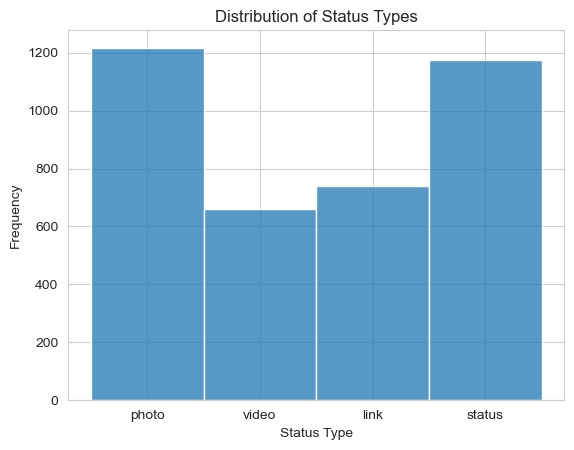

In [9]:
sns.set_style("whitegrid")

sns.histplot(data=corpus_df, x='status_type', binwidth=0.1)
plt.title('Distribution of Status Types')
plt.xlabel('Status Type')
plt.ylabel('Frequency')
plt.show()

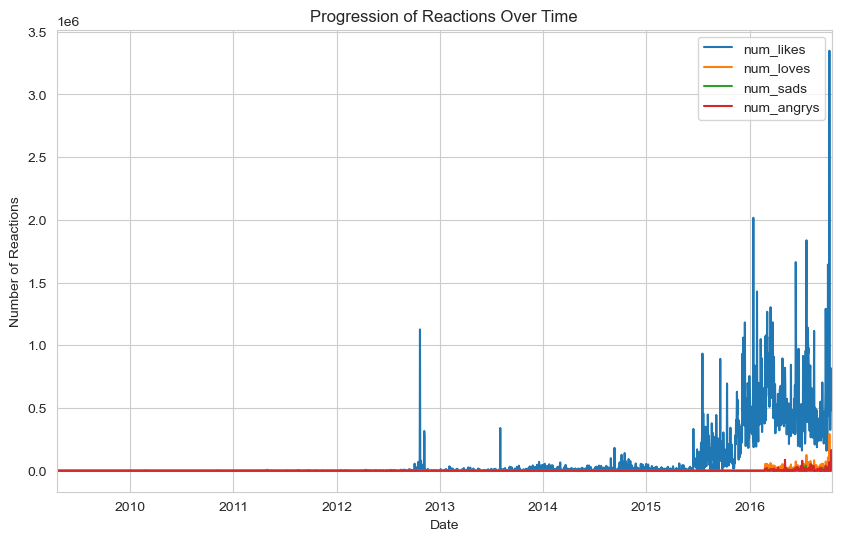

,num_likes,num_loves,num_sads,num_angrys
status_published,,,,
2009-04-16,482,0,0,0
2009-04-17,0,0,0,0
2009-04-18,0,0,0,0
2009-04-19,140,0,0,0
2009-04-20,152,0,0,0


In [10]:
# create new df with status_published column as index
date_df = corpus_df.set_index('status_published')
# filter out unnecessary columns
date_df = date_df[['num_likes', 'num_loves', 'num_sads', 'num_angrys']]
# resample data to daily frequency and sum values for each day
date_df = date_df.resample('D').sum()

# plot
date_df.plot(figsize=(10, 6))
plt.title('Progression of Reactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reactions')
plt.show()

date_df.head(5)

In [11]:
# Initialize and extend stop words
stop_words = stopwords.words('english')
stop_words.extend(['use', 'say', 'go', 'get', 'also', 'tell', 'take', 'see', 'want', 'many', 'come', 'even', 'com', 'tbt'])

In [12]:
# CLEAN TEXT
# convert tweets to list
data = corpus_df.status_message.values.tolist()

# Remove distracting single quotes
data = [re.sub(r"\'", "", sent) for sent in data]
# remove URLs
data = [re.sub(r"http\S+", "", sent) for sent in data]
# remove mentions
data = [re.sub(r"@\S+", "", sent) for sent in data]
# remove special characters
data = [re.sub(r"[^a-zA-Z0-9]+", " ", sent) for sent in data]

pprint(data[:1])
# pprint(data)

['Beautiful evening in Wisconsin THANK YOU for your incredible support tonight '
 'Everyone get out on November 8th and VOTE LETS MAKE AMERICA GREAT AGAIN DJT']


In [13]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc = True removes punc

data_words = list(sent_to_words(data))

print(data_words[:1])

[['beautiful', 'evening', 'in', 'wisconsin', 'thank', 'you', 'for', 'your', 'incredible', 'support', 'tonight', 'everyone', 'get', 'out', 'on', 'november', 'th', 'and', 'vote', 'lets', 'make', 'america', 'great', 'again', 'djt']]


In [14]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold = fewer phrases
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# word list with bigrams and trigrams
print(trigram_mod[bigram_mod[data_words[0]]])

['beautiful', 'evening', 'in', 'wisconsin', 'thank', 'you', 'for', 'your', 'incredible', 'support', 'tonight', 'everyone', 'get', 'out', 'on', 'november_th', 'and', 'vote', 'lets', 'make', 'america', 'great', 'again', 'djt']


In [15]:
## MORE CLEANING
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
print('stop words removed')

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
print('bigrams formed')

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
print('spacy loaded')

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print('data lemmatized')

# Remove Stop Words again
data_clean = remove_stopwords(data_lemmatized)
print('stop words removed')

print(data_lemmatized[:1])

stop words removed
bigrams formed
spacy loaded
data lemmatized
stop words removed
[['beautiful', 'evening', 'wisconsin', 'thank', 'incredible', 'support', 'tonight', 'vote', 'let', 'make']]


In [16]:
# Create dictionary
id2word = corpora.Dictionary(data_clean)

# create corpus
corpus = [id2word.doc2bow(text) for text in data_clean]

print(corpus[:1])
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]]


[[('beautiful', 1),
  ('evening', 1),
  ('incredible', 1),
  ('let', 1),
  ('make', 1),
  ('support', 1),
  ('thank', 1),
  ('tonight', 1),
  ('vote', 1),
  ('wisconsin', 1)]]

In [17]:
# Test for optimal number of passes for LDA model
passes = 40
chunksize = 2000
num_topics = 20

# Check for convergence using the log-likelihood values
log_likelihoods = []
for i in range(1, passes+1):
    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=num_topics,
        chunksize=2000,
        passes=i,
        alpha='auto',
        eta='auto',
        per_word_topics=True,
        random_state=42
    )
    log_likelihoods.append(lda_model.log_perplexity(corpus))
    if i > 1:
        if log_likelihoods[-1] - log_likelihoods[-2] < 0.001:
            print("Converged after %d passes" % i)
            passes = i
            break

Converged after 25 passes


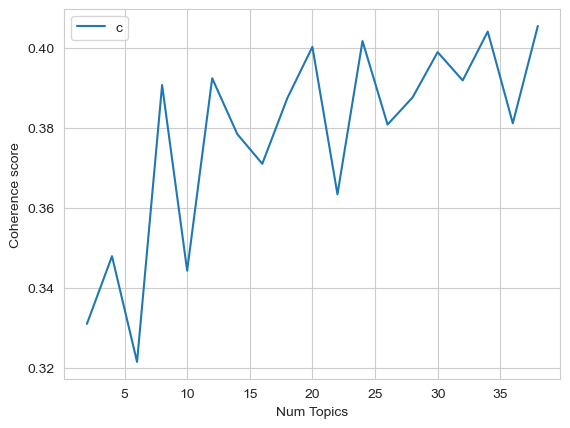

In [18]:
# Test for optimal number of topics for LDA model
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics = num_topics,
                                                random_state = 42,
                                                update_every = 1,
                                                chunksize = chunksize, 
                                                passes = passes,
                                                alpha='auto', 
                                                per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model,
                                        texts=texts,
                                        dictionary=dictionary,
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_clean,
                                                        start=2,
                                                        limit=40,
                                                        step=2)
# Show coherence plot
limit=40; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
# Test for optimal number of passes for LDA model again after selecting topic number
num_topics = 8

# Check for convergence using the log-likelihood values
log_likelihoods = []
for i in range(1, passes+1):
    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=num_topics,
        chunksize=2000,
        passes=i,
        alpha='auto',
        eta='auto',
        per_word_topics=True,
        random_state=42
    )
    log_likelihoods.append(lda_model.log_perplexity(corpus))
    if i > 1:
        if log_likelihoods[-1] - log_likelihoods[-2] < 0.001:
            print("Converged after %d passes" % i)
            passes = i
            break

Converged after 15 passes


In [20]:
# LDA MODEL 1 - 8 topics
lda_model1 = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                      id2word = id2word,
                                      num_topics = num_topics,
                                      random_state = 42,
                                      update_every = 1,
                                      chunksize = chunksize, 
                                      passes = passes,
                                      alpha='auto', 
                                      per_word_topics=True)

# Print the log-likelihood of the model
print('Log-likelihood of the model: ', lda_model1.log_perplexity(corpus), '\n')
## topic word distributions
for topic_id in range(lda_model1.num_topics):

    topk = lda_model1.show_topic(topic_id, 10)
    topk_words = [ w for w, _ in topk ]

    print('{}: {}'.format(topic_id, ' '.join(topk_words)))

Log-likelihood of the model:  -7.419538622948402 

0: great thank make trump support vote together safe let time
1: job new country work plan american campaign make pay year
2: trump need people win run country well good vote think
3: trump show great campaign golf today debate day tonight collection
4: veteran united_state people great trump first state good care honor
5: tower trump question crook hillary answer time medium think people
6: trump president watch interview live time day show join week
7: people country american make know year job never crime change


In [21]:
# LDA MODEL 2 - 12 topics
# Test for optimal number of passes for LDA model again after selecting topic number
num_topics = 12
passes = 40
# Check for convergence using the log-likelihood values
log_likelihoods = []
for i in range(1, passes+1):
    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=num_topics,
        chunksize=2000,
        passes=i,
        alpha='auto',
        eta='auto',
        per_word_topics=True,
        random_state=42
    )
    log_likelihoods.append(lda_model.log_perplexity(corpus))
    if i > 1:
        if log_likelihoods[-1] - log_likelihoods[-2] < 0.001:
            print("Converged after %d passes" % i)
            passes = i
            break

# MODEL 2
lda_model2 = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                      id2word = id2word,
                                      num_topics = num_topics,
                                      random_state = 42,
                                      update_every = 1,
                                      chunksize = chunksize, 
                                      passes = passes,
                                      alpha='auto', 
                                      per_word_topics=True)

# Print the log-likelihood of the model
print('Log-likelihood of the model: ', lda_model2.log_perplexity(corpus), '\n')
## topic word distributions
for topic_id in range(lda_model2.num_topics):

    topk = lda_model2.show_topic(topic_id, 10)
    topk_words = [ w for w, _ in topk ]

    print('{}: {}'.format(topic_id, ' '.join(topk_words)))

Converged after 30 passes
Log-likelihood of the model:  -7.520703086361195 

0: great thank make support vote together safe trump let time
1: plan work campaign year country family child dollar tax increase
2: gopdebate need trump well win talk much politician country good
3: campaign trump vote celebapprentice collection republican candidate caucus show star
4: respect people receive trump veteran care leader good serve honor
5: crook trump hillary tower debate question time crooked thought answer
6: trump president show next pm season hotel book day united_state
7: people country fight american try know year lose tough obama
8: job american new make country people deal trade worker create
9: people country time clinton government make pay give life crime
10: trump watch today morning proud video woman honor ivanka show
11: tonight great apprentice live enjoy miss watch really trump fantastic


In [22]:
# LDA MODEL 3 - 20 topics
# Test for optimal number of passes for LDA model again after selecting topic number
num_topics = 20
passes = 40
# Check for convergence using the log-likelihood values
log_likelihoods = []
for i in range(1, passes+1):
    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=num_topics,
        chunksize=2000,
        passes=i,
        alpha='auto',
        eta='auto',
        per_word_topics=True,
        random_state=42
    )
    log_likelihoods.append(lda_model.log_perplexity(corpus))
    if i > 1:
        if log_likelihoods[-1] - log_likelihoods[-2] < 0.001:
            print("Converged after %d passes" % i)
            passes = i
            break

# MODEL
lda_model3 = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                      id2word = id2word,
                                      num_topics = num_topics,
                                      random_state = 42,
                                      update_every = 1,
                                      chunksize = chunksize, 
                                      passes = passes,
                                      alpha='auto', 
                                      per_word_topics=True)

# Print the log-likelihood of the model
print('Log-likelihood of the model: ', lda_model3.log_perplexity(corpus), '\n')
## topic word distributions
for topic_id in range(lda_model3.num_topics):

    topk = lda_model3.show_topic(topic_id, 10)
    topk_words = [ w for w, _ in topk ]

    print('{}: {}'.format(topic_id, ' '.join(topk_words)))

Converged after 25 passes
Log-likelihood of the model:  -8.299542083170646 

0: great make thank together safe vote support time let love
1: apprentice campaign season start new success hotel country focus work
2: run win race tune cruz guy last congratulation lyin_te statement
3: deal show well much hillary cast crook never lie look
4: good time speak military people find care experience last_night receive
5: trump question tower pm record answer organization medium lot facebook
6: trump president open happy case day office university obamacare blog
7: people bad attack never terrorism isis obama know change world
8: american country job people new future year stop crime worker
9: people life big country never chance give citizen know money
10: trump thank support vote let great today trumptrain join amazing
11: watch tonight live video trump ivanka join interview week enjoy
12: job people country well first bring strong believe right back
13: gopdebate campaign people crook work cand

In [23]:
# LDA MODEL 4 - 24 topics FINAL MODEL
# Test for optimal number of passes for LDA model again after selecting topic number
num_topics = 24
passes = 40
# Check for convergence using the log-likelihood values
log_likelihoods = []
for i in range(1, passes+1):
    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=num_topics,
        chunksize=2000,
        passes=i,
        alpha='auto',
        eta='auto',
        per_word_topics=True,
        random_state=42
    )
    log_likelihoods.append(lda_model.log_perplexity(corpus))
    if i > 1:
        if log_likelihoods[-1] - log_likelihoods[-2] < 0.001:
            print("Converged after %d passes" % i)
            passes = i
            break

# LDA MODEL 4 FINAL MODEL
lda_model4 = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                      id2word = id2word,
                                      num_topics = num_topics,
                                      random_state = 42,
                                      update_every = 1,
                                      chunksize = chunksize, 
                                      passes = passes,
                                      alpha='auto', 
                                      per_word_topics=True)

# Print the log-likelihood of the model
print('Log-likelihood of the model: ', lda_model4.log_perplexity(corpus), '\n')
## topic word distributions
for topic_id in range(lda_model4.num_topics):

    topk = lda_model4.show_topic(topic_id, 10)
    topk_words = [ w for w, _ in topk ]

    print('{}: {}'.format(topic_id, ' '.join(topk_words)))

Converged after 29 passes
Log-likelihood of the model:  -8.462851704825473 

0: great thank make support vote safe together let trump time
1: campaign work plan grow put continue first childcare make country
2: trump cruz voter race person fun momentum hope lyin_te fact
3: really well much campaign late tomorrow special show official people
4: people email clinton criminal election collection hand obama life server
5: debate crowd thought people big agree lose record top win
6: rating trump university case congratulation blog fantastic incompetent school terrific
7: people attack country terrorism bad kill immigration terrorist isis victim
8: american job new tax country year trade policy plan future
9: people system country law government time problem work break crime
10: trump honor great tower today golf wonderful proud world show
11: gopdebate video watch speech week facebook great night miss office
12: job country people make bring change thing american money back
13: receive endo

In [24]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

C:\Users\Alex\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.185030 -0.311808       1        1  12.806060
12     0.161305 -0.128187       2        1  11.324033
8      0.141441 -0.139833       3        1   8.398545
9      0.148343 -0.059690       4        1   7.873027
7      0.138264  0.007669       5        1   4.881544
10    -0.214591 -0.093866       6        1   4.670669
23     0.114038 -0.086096       7        1   4.584754
20    -0.012992 -0.062722       8        1   4.410438
22    -0.095236 -0.019219       9        1   4.150066
15     0.082245 -0.017927      10        1   3.870345
1      0.096035 -0.043930      11        1   3.463668
18    -0.166865  0.046292      12        1   3.251255
4      0.070420  0.059434      13        1   2.861633
6     -0.033204  0.089227      14        1   2.505647
11    -0.106244  0.035922      15        1   2.358745
19    -0.089319  0.046373      16        1   2.334262
16    -0.046826  0.048413      17        1   2.327056
3     -0.073751  0.095610      18        1   2.295684
21     0.033715  0.096673      19        1   2.276952
13    -0.051668  0.071440      20        1   2.271619
17     0.079490  0.084773      21        1   2.029017
2     -0.048844  0.093502      22        1   1.981937
5      0.009703  0.100305      23        1   1.734584
14     0.049570  0.087645      24        1   1.338457, topic_info=                Term         Freq        Total Category  logprob  loglift
6              thank   768.000000   768.000000  Default  30.0000  30.0000
157            great  1073.000000  1073.000000  Default  29.0000  29.0000
57             trump   773.000000   773.000000  Default  28.0000  28.0000
4               make   902.000000   902.000000  Default  27.0000  27.0000
7            tonight   158.000000   158.000000  Default  26.0000  26.0000
..               ...          ...          ...      ...      ...      ...
386  law_enforcement     5.373350    34.898929  Topic24  -4.8146   2.4426
301   administration     4.986569    38.726611  Topic24  -4.8893   2.2639
22            people     8.398483   508.018470  Topic24  -4.3680   0.2112
224              job     7.330369   323.940475  Topic24  -4.5041   0.5251
138            never     3.976098   134.648162  Topic24  -5.1158   0.7913

[1443 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1302      2  0.929993     abandon
3370     14  0.800516    accolade
781       2  0.900458  accomplish
1305     10  0.924769     account
531       2  0.080125      action
...     ...       ...         ...
983       4  0.361782       young
983      11  0.470317       young
983      16  0.108535       young
3952     15  0.721727     youtube
3896      7  0.810870        zone

[3448 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 13, 9, 10, 8, 11, 24, 21, 23, 16, 2, 19, 5, 7, 12, 20, 17, 4, 22, 14, 18, 3, 6, 15])

In [25]:
# document topic distributions
all_topics = lda_model.get_document_topics(corpus, per_word_topics=True)

for doc_topics, word_topics, phi_values in all_topics:
    print('New Document \n')
    print('Document topics:', doc_topics)
    # print('Word topics:', word_topics)
    # print('Phi values:', phi_values)
    print(' ')
    print('-------------- \n')

New Document 

Document topics: [(0, 0.74691033), (13, 0.09743296), (18, 0.08250997)]
 
-------------- 

New Document 

Document topics: [(9, 0.91214615), (21, 0.044821195)]
 
-------------- 

New Document 

Document topics: [(0, 0.10679175), (20, 0.57153), (21, 0.19404553), (23, 0.10421913)]
 
-------------- 

New Document 

Document topics: [(0, 0.034306157), (2, 0.1814439), (10, 0.26370636), (20, 0.39807987)]
 
-------------- 

New Document 

Document topics: [(0, 0.01631178), (19, 0.9177326)]
 
-------------- 

New Document 

Document topics: [(0, 0.017498804), (12, 0.4831962), (18, 0.4329281)]
 
-------------- 

New Document 

Document topics: [(0, 0.026050085), (2, 0.12897587), (5, 0.25088692), (18, 0.34567547), (21, 0.15718336)]
 
-------------- 

New Document 

Document topics: [(0, 0.32745752), (10, 0.012777831), (20, 0.5321697)]
 
-------------- 

New Document 

Document topics: [(9, 0.43798575), (12, 0.32921597), (23, 0.1901018)]
 
-------------- 

New Document 

Document to

New Document 

Document topics: [(0, 0.62757653), (10, 0.015278931), (18, 0.01092228), (19, 0.20320927), (22, 0.010963223)]
 
-------------- 

New Document 

Document topics: [(0, 0.041566774), (3, 0.20161648), (10, 0.015279106), (18, 0.4024181), (22, 0.010963399), (23, 0.20437245)]
 
-------------- 

New Document 

Document topics: [(0, 0.7331172), (19, 0.09786473), (22, 0.09623789)]
 
-------------- 

New Document 

Document topics: [(0, 0.010829612), (12, 0.32687142), (17, 0.61863)]
 
-------------- 

New Document 

Document topics: [(0, 0.93602276)]
 
-------------- 

New Document 

Document topics: [(0, 0.06033544), (4, 0.77258193), (20, 0.15491585)]
 
-------------- 

New Document 

Document topics: [(0, 0.015743118), (6, 0.088528626), (12, 0.5830687), (22, 0.14083108), (23, 0.11650137)]
 
-------------- 

New Document 

Document topics: [(0, 0.2935589), (10, 0.01899733), (11, 0.011021187), (12, 0.010521841), (18, 0.013580579), (20, 0.0109904), (22, 0.01363149), (23, 0.49756625)]

New Document 

Document topics: [(0, 0.021233907), (1, 0.013814572), (4, 0.06681311), (7, 0.052575298), (8, 0.29083064), (9, 0.21460626), (12, 0.24590057), (15, 0.033943333), (20, 0.024898943), (23, 0.010429622)]
 
-------------- 

New Document 

Document topics: [(4, 0.98415333)]
 
-------------- 

New Document 

Document topics: [(0, 0.025509842), (9, 0.3538853), (10, 0.33216304), (12, 0.1963708)]
 
-------------- 

New Document 

Document topics: [(0, 0.02543306), (2, 0.6010467), (23, 0.2715791)]
 
-------------- 

New Document 

Document topics: [(0, 0.022639789), (4, 0.6962319), (7, 0.18928154)]
 
-------------- 

New Document 

Document topics: [(0, 0.38315433), (10, 0.16981868), (18, 0.14518034), (23, 0.23663458)]
 
-------------- 

New Document 

Document topics: [(0, 0.17439888), (5, 0.1501792), (7, 0.30721518), (20, 0.09720993), (22, 0.21549885)]
 
-------------- 

New Document 

Document topics: [(0, 0.033930723), (10, 0.012777868), (12, 0.50868404), (22, 0.3258651)]
 
-----

New Document 

Document topics: [(0, 0.2428529), (11, 0.66302013)]
 
-------------- 

New Document 

Document topics: [(0, 0.02039482), (19, 0.4187975), (21, 0.08331766), (23, 0.40012577)]
 
-------------- 

New Document 

Document topics: [(0, 0.025469659), (13, 0.13160028), (21, 0.23528849), (22, 0.51215047)]
 
-------------- 

New Document 

Document topics: [(0, 0.025526736), (21, 0.6159923), (22, 0.25876534)]
 
-------------- 

New Document 

Document topics: [(0, 0.02992575), (10, 0.28784603), (13, 0.57105064)]
 
-------------- 

New Document 

Document topics: [(0, 0.025500052), (7, 0.867731)]
 
-------------- 

New Document 

Document topics: [(0, 0.015728405), (7, 0.9182356)]
 
-------------- 

New Document 

Document topics: [(0, 0.022673476), (17, 0.42556253), (22, 0.46155697)]
 
-------------- 

New Document 

Document topics: [(0, 0.7034511), (16, 0.21884158)]
 
-------------- 

New Document 

Document topics: [(0, 0.6118999), (6, 0.10156722), (21, 0.09343934), (23, 0.1223

New Document 

Document topics: [(16, 0.3803186), (23, 0.58560705)]
 
-------------- 

New Document 

Document topics: [(3, 0.29956704), (4, 0.11706009), (9, 0.3639137), (15, 0.12438452), (21, 0.07796223)]
 
-------------- 

New Document 

Document topics: [(16, 0.7409951), (23, 0.22977361)]
 
-------------- 

New Document 

Document topics: [(0, 0.38169667), (5, 0.10262658), (6, 0.32173392), (10, 0.11943381)]
 
-------------- 

New Document 

Document topics: [(1, 0.12746844), (23, 0.8366382)]
 
-------------- 

New Document 

Document topics: [(0, 0.7919907), (16, 0.12261896)]
 
-------------- 

New Document 

Document topics: [(0, 0.02164462), (9, 0.26674458), (18, 0.42569497), (19, 0.20936003)]
 
-------------- 

New Document 

Document topics: [(1, 0.087554716), (4, 0.05529752), (8, 0.19314745), (9, 0.15633138), (12, 0.34599796), (17, 0.043602217), (19, 0.104982734)]
 
-------------- 

New Document 

Document topics: [(0, 0.74230534), (9, 0.19618458)]
 
-------------- 

New Docume

New Document 

Document topics: [(0, 0.025515376), (14, 0.51790845), (23, 0.35422114)]
 
-------------- 

New Document 

Document topics: [(0, 0.018705484), (6, 0.093051516), (7, 0.101794675), (14, 0.108759314), (18, 0.6103954)]
 
-------------- 

New Document 

Document topics: [(0, 0.020529414), (5, 0.22629508), (7, 0.41265035), (14, 0.26138288)]
 
-------------- 

New Document 

Document topics: [(0, 0.1711817), (20, 0.25638658), (21, 0.29101393), (22, 0.18725383)]
 
-------------- 

New Document 

Document topics: [(0, 0.018647099), (10, 0.6495614), (20, 0.26162183)]
 
-------------- 

New Document 

Document topics: [(0, 0.87302476), (10, 0.0109800175)]
 
-------------- 

New Document 

Document topics: [(0, 0.57408917), (13, 0.34000862)]
 
-------------- 

New Document 

Document topics: [(0, 0.022750106), (21, 0.8823256)]
 
-------------- 

New Document 

Document topics: [(0, 0.1728709), (6, 0.2647947), (9, 0.42577744), (10, 0.012784798)]
 
-------------- 

New Document 

Docum

New Document 

Document topics: [(0, 0.62962174), (3, 0.2988004)]
 
-------------- 

New Document 

Document topics: [(0, 0.6816509), (10, 0.23677321)]
 
-------------- 

New Document 

Document topics: [(0, 0.8730245), (10, 0.010980604)]
 
-------------- 

New Document 

Document topics: [(0, 0.7444749), (13, 0.18378851)]
 
-------------- 

New Document 

Document topics: [(0, 0.050675184), (10, 0.20814355), (11, 0.0110209985), (12, 0.0105216615), (13, 0.54884195), (18, 0.013580347), (20, 0.010990213), (22, 0.013631258), (23, 0.010813671)]
 
-------------- 

New Document 

Document topics: [(0, 0.050491106), (10, 0.23404275), (11, 0.0110210385), (12, 0.0105217), (18, 0.013580396), (20, 0.010990252), (21, 0.24810883), (22, 0.28956306), (23, 0.01081371)]
 
-------------- 

New Document 

Document topics: [(0, 0.5597105), (2, 0.25421718), (21, 0.103672326)]
 
-------------- 

New Document 

Document topics: [(0, 0.029004237), (9, 0.14835131), (10, 0.010982135), (12, 0.42529005), (22, 0.1

New Document 

Document topics: [(0, 0.75411505), (2, 0.12335592), (10, 0.010980523)]
 
-------------- 

New Document 

Document topics: [(0, 0.24432005), (5, 0.293007), (7, 0.17478068), (10, 0.21368736)]
 
-------------- 

New Document 

Document topics: [(0, 0.06631016), (2, 0.010180023), (3, 0.011574072), (5, 0.0120400395), (6, 0.010957057), (7, 0.011926564), (8, 0.01062213), (9, 0.011213603), (10, 0.025107639), (11, 0.65790576), (12, 0.013906127), (13, 0.011034073), (16, 0.012695434), (18, 0.017948693), (19, 0.012279088), (20, 0.014525395), (21, 0.012242769), (22, 0.018015975), (23, 0.014292066)]
 
-------------- 

New Document 

Document topics: [(0, 0.57196414), (1, 0.014129188), (2, 0.015007449), (3, 0.017062565), (4, 0.013763398), (5, 0.017749498), (6, 0.016152957), (7, 0.017582212), (8, 0.015659206), (9, 0.01653116), (10, 0.037013818), (11, 0.021473406), (12, 0.020500494), (13, 0.016266497), (14, 0.013403397), (15, 0.01350457), (16, 0.018715683), (17, 0.0118679525), (18, 0.026

New Document 

Document topics: [(0, 0.66090107), (1, 0.26052547)]
 
-------------- 

New Document 

Document topics: [(0, 0.014952976), (16, 0.32425258), (20, 0.32389262), (23, 0.28206295)]
 
-------------- 

New Document 

Document topics: [(0, 0.7803161), (10, 0.018996876), (11, 0.0110209435), (12, 0.010521609), (18, 0.013580279), (20, 0.010990158), (22, 0.013631189), (23, 0.010813617)]
 
-------------- 

New Document 

Document topics: [(0, 0.7739559), (5, 0.09340712), (10, 0.08053587)]
 
-------------- 

New Document 

Document topics: [(0, 0.7488768), (16, 0.08215787), (22, 0.10738853)]
 
-------------- 

New Document 

Document topics: [(0, 0.3807723), (10, 0.012778026), (13, 0.47708124)]
 
-------------- 

New Document 

Document topics: [(0, 0.013627454), (3, 0.932569)]
 
-------------- 

New Document 

Document topics: [(0, 0.017873196), (2, 0.44142118), (9, 0.019138876), (12, 0.30283973), (17, 0.058706224), (21, 0.03381559), (23, 0.12202781)]
 
-------------- 

New Document 

New Document 

Document topics: [(0, 0.04054994), (10, 0.01527932), (14, 0.3968087), (18, 0.0109225605), (19, 0.3989556), (22, 0.010963507)]
 
-------------- 

New Document 

Document topics: [(0, 0.91874367)]
 
-------------- 

New Document 

Document topics: [(0, 0.55921304), (16, 0.35539785)]
 
-------------- 

New Document 

Document topics: [(0, 0.014500918), (5, 0.12207851), (10, 0.7232584), (18, 0.09175272)]
 
-------------- 

New Document 

Document topics: [(0, 0.05092173), (10, 0.018997202), (11, 0.011021152), (12, 0.010521808), (18, 0.7429709), (20, 0.010990365), (22, 0.013631457), (23, 0.010813822)]
 
-------------- 

New Document 

Document topics: [(0, 0.020491572), (13, 0.5380099), (15, 0.25919127), (21, 0.10298509)]
 
-------------- 

New Document 

Document topics: [(0, 0.45520687), (2, 0.010180004), (3, 0.01157405), (5, 0.012040017), (6, 0.010957036), (7, 0.011926543), (8, 0.01062211), (9, 0.011213583), (10, 0.27955112), (11, 0.014566057), (12, 0.013906101), (13, 0.01

New Document 

Document topics: [(0, 0.16902615), (1, 0.2552096), (2, 0.07946949), (13, 0.054926198), (14, 0.0733122), (16, 0.11664574), (18, 0.095820606), (22, 0.12438757)]
 
-------------- 

New Document 

Document topics: [(0, 0.043974962), (5, 0.3988133), (6, 0.39451984), (10, 0.0152790835), (18, 0.010922257), (22, 0.010963203)]
 
-------------- 

New Document 

Document topics: [(0, 0.040354174), (10, 0.015278477), (18, 0.79388475), (22, 0.010963037)]
 
-------------- 

New Document 

Document topics: [(0, 0.14619915), (2, 0.14512004), (10, 0.010980559), (18, 0.43369403), (22, 0.16818698)]
 
-------------- 

New Document 

Document topics: [(0, 0.030757574), (5, 0.16069941), (10, 0.010980246), (18, 0.6946812)]
 
-------------- 

New Document 

Document topics: [(0, 0.44365206), (7, 0.4613183)]
 
-------------- 

New Document 

Document topics: [(0, 0.06821958), (2, 0.010180193), (3, 0.33132812), (5, 0.012040241), (6, 0.01095724), (7, 0.011926765), (8, 0.010622307), (9, 0.011213792

New Document 

Document topics: [(0, 0.040352553), (5, 0.2030658), (9, 0.21954894), (10, 0.015279095), (14, 0.2012739), (16, 0.18647769), (18, 0.010922541), (22, 0.010963487)]
 
-------------- 

New Document 

Document topics: [(0, 0.050725218), (4, 0.30701515), (10, 0.018998045), (11, 0.44064784), (12, 0.010522276), (18, 0.01358114), (20, 0.010990854), (22, 0.013632054), (23, 0.010814303)]
 
-------------- 

New Document 

Document topics: [(0, 0.018816141), (2, 0.1769261), (7, 0.36530685), (12, 0.24894731), (15, 0.121381)]
 
-------------- 

New Document 

Document topics: [(0, 0.18845578), (5, 0.08257258), (6, 0.09650354), (7, 0.31603584), (16, 0.16601317), (19, 0.09576003)]
 
-------------- 

New Document 

Document topics: [(0, 0.09862234), (1, 0.48746845), (2, 0.015007541), (3, 0.01706267), (4, 0.013763482), (5, 0.017749606), (6, 0.016153056), (7, 0.01758232), (8, 0.015659302), (9, 0.016531263), (10, 0.03701402), (11, 0.021473538), (12, 0.020500619), (13, 0.016266596), (14, 0.013

New Document 

Document topics: [(0, 0.025568943), (2, 0.13131224), (5, 0.19548607), (6, 0.12933828), (10, 0.13851403), (18, 0.13021067), (20, 0.17303792)]
 
-------------- 

New Document 

Document topics: [(0, 0.13354288), (11, 0.23815952), (19, 0.36314404), (20, 0.188579)]
 
-------------- 

New Document 

Document topics: [(0, 0.5228545), (10, 0.015278833), (14, 0.30599037), (18, 0.010922386), (22, 0.010963331)]
 
-------------- 

New Document 

Document topics: [(0, 0.06631139), (2, 0.010180211), (3, 0.011574286), (5, 0.012040262), (6, 0.010957259), (7, 0.011926785), (8, 0.010622326), (9, 0.011213811), (10, 0.6684412), (11, 0.014566353), (12, 0.013906384), (13, 0.011034277), (16, 0.012695668), (18, 0.01794902), (19, 0.012279315), (20, 0.014525666), (21, 0.012242995), (22, 0.018016309), (23, 0.0142923305)]
 
-------------- 

New Document 

Document topics: [(0, 0.19743824), (1, 0.16857192), (10, 0.012779093), (12, 0.4981657)]
 
-------------- 

New Document 

Document topics: [(0, 

New Document 

Document topics: [(0, 0.013751991), (8, 0.2586812), (9, 0.28773454), (18, 0.08054498), (20, 0.3107158)]
 
-------------- 

New Document 

Document topics: [(0, 0.050375935), (10, 0.01899749), (11, 0.01102132), (12, 0.49707273), (18, 0.013580742), (19, 0.25267285), (20, 0.010990533), (22, 0.013631658), (23, 0.010813986)]
 
-------------- 

New Document 

Document topics: [(0, 0.013028308), (5, 0.100885645), (10, 0.39999494), (11, 0.087817706), (18, 0.2790695), (21, 0.0789734)]
 
-------------- 

New Document 

Document topics: [(0, 0.14317617), (5, 0.054516602), (9, 0.5741692), (11, 0.102113836), (23, 0.09251999)]
 
-------------- 

New Document 

Document topics: [(5, 0.14766598), (11, 0.25928608), (13, 0.20323175), (18, 0.10834106), (19, 0.24083516)]
 
-------------- 

New Document 

Document topics: [(0, 0.022694368), (1, 0.2239074), (16, 0.41463456), (18, 0.25339332)]
 
-------------- 

New Document 

Document topics: [(4, 0.11017169), (6, 0.052650314), (12, 0.1026447

In [26]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model4, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic = df_dominant_topic.rename({'index': 'Document_Num'}, axis=1)
df_dominant_topic.head(10)

C:\Users\Alex\AppData\Local\Temp\ipykernel_24008\2834465762.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_24008\2834465762.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_Num,Dominant_Topic,Perc_Contribution,Topic_Keywords
0,0,0,0.7469,"great, thank, make, support, vote, safe, toget..."
1,1,9,0.9121,"people, system, country, law, government, time..."
2,2,20,0.5715,"think, know, people, book, friend, read, need,..."
3,3,20,0.3979,"think, know, people, book, friend, read, need,..."
4,4,19,0.9177,"trump, fire, find, check, caucus, early, locat..."
5,5,12,0.4832,"job, country, people, make, bring, change, thi..."
6,6,18,0.3457,"tonight, watch, live, morning, show, pm, join,..."
7,7,20,0.5322,"think, know, people, book, friend, read, need,..."
8,8,9,0.4379,"people, system, country, law, government, time..."
9,9,16,0.4975,"apprentice, way, deal, call, hotel, time, long..."


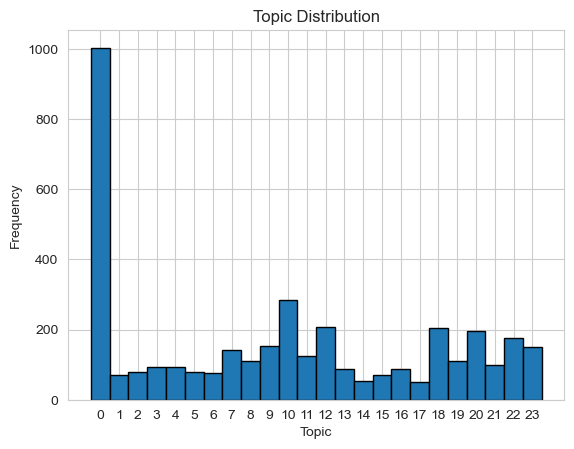

In [27]:
# create topic freq hist
plt.hist(df_dominant_topic['Dominant_Topic'], bins=np.arange(25)-0.5, edgecolor='black')
# titles
plt.title("Topic Distribution")
plt.xlabel("Topic")
plt.ylabel("Frequency")
# ticks
plt.xticks(np.arange(24))

plt.show()

In [28]:
# Add dominant topic column to main corpus dataframe
corpus_df['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].astype(int)

# Filter the dataframe to only include the top 10 topics
top10_topics = corpus_df['Dominant_Topic'].value_counts().nlargest(10).index.tolist()
df_top10 = corpus_df.loc[corpus_df['Dominant_Topic'].isin(top10_topics)]

# sum likes and loves to make a num_happy column. sad and angry for num_upset
df_top10['num_happy'] = df_top10['num_likes'] + df_top10['num_loves'] + df_top10['num_hahas']
df_top10['num_upset'] = df_top10['num_sads'] + df_top10['num_angrys']

df_top10.columns

C:\Users\Alex\AppData\Local\Temp\ipykernel_24008\2470062555.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top10['num_happy'] = df_top10['num_likes'] + df_top10['num_loves'] + df_top10['num_hahas']
C:\Users\Alex\AppData\Local\Temp\ipykernel_24008\2470062555.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top10['num_upset'] = df_top10['num_sads'] + df_top10['num_angrys']


Index(['status_message', 'status_type', 'status_published', 'num_reactions',
       'num_comments', 'num_shares', 'num_likes', 'num_loves', 'num_wows',
       'num_hahas', 'num_sads', 'num_angrys', 'Dominant_Topic', 'num_happy',
       'num_upset'],
      dtype='object')

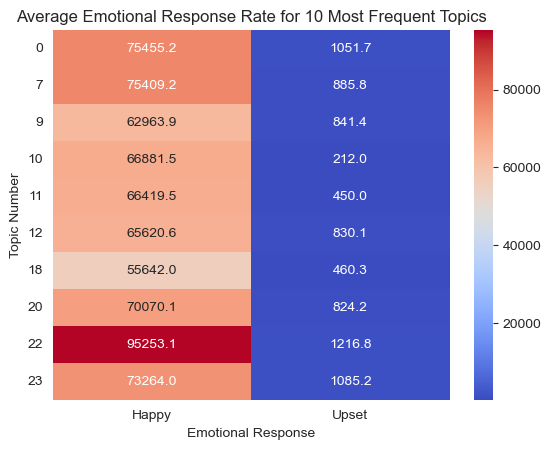

In [35]:
# create pivot table with mean values of num_happy and num_upset for each Dominant_Topic
pivot_df = df_top10[['Dominant_Topic', 'num_happy', 'num_upset']].pivot_table(index='Dominant_Topic', 
                                                                         values=['num_happy', 'num_upset'], 
                                                                         aggfunc='mean')

# create heatmap
heatmap = sns.heatmap(data=pivot_df, cmap='coolwarm', annot=True, fmt=".1f")
heatmap.set_title('Average Emotional Response Rate for 10 Most Frequent Topics')
heatmap.set_xlabel('Emotional Response')
heatmap.set_ylabel('Topic Number')
heatmap.set_xticklabels(['Happy', 'Upset'])
heatmap.set_yticklabels(['0', '7', '9', '10', '11', '12', '18', '20', '22', '23'], rotation=0)

plt.show()

In [30]:
# Find 5 topics with the most shares
top5_topics_shares = corpus_df.groupby('Dominant_Topic').agg({'num_shares': 'sum'}).sort_values(by='num_shares', ascending=False).head(5).index
df_top5_shares = corpus_df[corpus_df['Dominant_Topic'].isin(top5_topics_shares)]
# Find 5 topics with the most reactions
top5_topics_reactions = corpus_df.groupby('Dominant_Topic').agg({'num_reactions': 'sum'}).sort_values(by='num_reactions', ascending=False).head(5).index
df_top5_reactions = corpus_df[corpus_df['Dominant_Topic'].isin(top5_topics_reactions)]

df_top5_reactions

,status_message,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Dominant_Topic
0,Beautiful evening in Wisconsin- THANK YOU for ...,photo,2016-10-17 20:56:51,6813,543,359,6178,572,39,17,0,7,0.0
2,Crooked Hillary's State Department colluded wi...,video,2016-10-17 15:34:46,85627,8810,32594,73519,2943,1020,330,263,7552,20.0
3,"JournoCash: Media gives $382,000 to Clinton, $...",link,2016-10-17 14:17:24,22696,3665,5082,14029,122,2091,241,286,5927,20.0
5,Of course there is large scale voter fraud hap...,status,2016-10-17 11:00:12,51108,6773,3266,45046,684,213,229,290,4646,12.0
7,We have all got to come together and win this ...,status,2016-10-17 10:25:35,144823,6975,10088,136689,6688,105,919,61,363,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3774,"""The only way to do great work is to love what...",status,2014-03-18 16:49:39,28750,779,5270,28750,0,0,0,0,0,20.0
3775,"""The best vision is insight."" -- Malcolm Forbes",status,2014-03-17 17:27:14,7499,303,767,7499,0,0,0,0,0,20.0
3785,"Judy Garland was much better, to put it mildly...",status,2014-03-02 22:38:02,3701,1099,101,3701,0,0,0,0,0,20.0
3786,"Whatever happened to ""old Hollywood""? So much...",status,2014-03-02 22:17:46,9588,1342,358,9588,0,0,0,0,0,20.0


In [31]:
# only keep most shared topics
df_filtered = df_dominant_topic[(df_dominant_topic['Dominant_Topic'].isin([0, 7, 10, 20, 22]))]
# drop 'Document_Num' and 'Perc_Contribution' columns
df_filtered = df_filtered.drop(['Document_Num', 'Perc_Contribution'], axis=1)
# drop duplicate rows based on 'Dominant_Topic' column and keep the first occurrence
df_filtered = df_filtered.drop_duplicates(subset=['Dominant_Topic'], keep='first')

df_filtered.head(5)

,Dominant_Topic,Topic_Keywords
0,0,"great, thank, make, support, vote, safe, toget..."
2,20,"think, know, people, book, friend, read, need,..."
36,22,"president, win, defeat, season, run, trump, ne..."
74,10,"trump, honor, great, tower, today, golf, wonde..."
85,7,"people, attack, country, terrorism, bad, kill,..."


In [37]:
# only keep most reacted topics
df_filtered = df_dominant_topic[(df_dominant_topic['Dominant_Topic'].isin([0, 10, 12, 20, 22]))]
# drop 'Document_Num' and 'Perc_Contribution' columns
df_filtered = df_filtered.drop(['Document_Num', 'Perc_Contribution'], axis=1)
# drop duplicate rows based on 'Dominant_Topic' column and keep the first occurrence
df_filtered = df_filtered.drop_duplicates(subset=['Dominant_Topic'], keep='first')

df_filtered

,Dominant_Topic,Topic_Keywords
0,0,"great, thank, make, support, vote, safe, toget..."
2,20,"think, know, people, book, friend, read, need,..."
5,12,"job, country, people, make, bring, change, thi..."
36,22,"president, win, defeat, season, run, trump, ne..."
74,10,"trump, honor, great, tower, today, golf, wonde..."


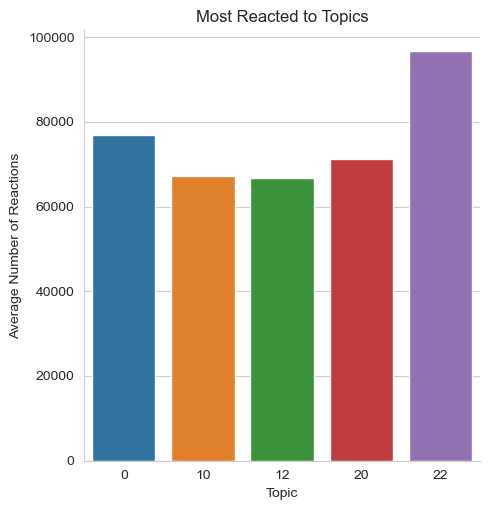

In [38]:
sns.catplot(x='Dominant_Topic', y='num_reactions', data=df_top5_reactions, kind='bar', ci=None)
plt.title('Most Reacted to Topics')
plt.xlabel('Topic')
plt.ylabel('Average Number of Reactions')
plt.gca().set_xticklabels(['0', '10', '12', '20', '22'])
plt.show()

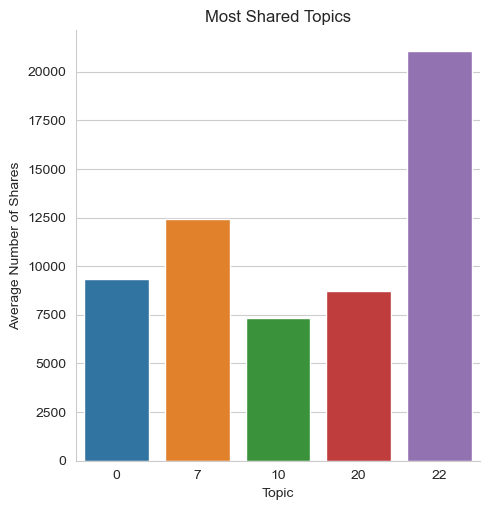

In [39]:
sns.catplot(x='Dominant_Topic', y='num_shares', data=df_top5_shares, kind='bar', ci=None)
plt.title('Most Shared Topics')
plt.xlabel('Topic')
plt.ylabel('Average Number of Shares')
plt.gca().set_xticklabels(['0', '7', '10', '20', '22'])
plt.show()